In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels

In [3]:
import sys
sys.path.append('..')

In [7]:
sc.read_h5ad('/tmp/raw_mouse_kidney_14.h5ad').X.toarray().max()

6495.0

In [8]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
# from spaceoracle.tools.utils import scale_adata
# adata = scale_adata(adata, cell_size=10)
# adata

In [155]:
adata.obs.ct1 = adata.obs.ct1.astype(str)
adata = adata[~adata.obs.ct1.isin(["Neuronal", "Erythroid"])]

In [156]:
# adata.obs = adata.obs.drop(columns=
#     ['batch', 'rxn', 
#      'n_counts', 'high_q', 'chip', 'exp', 'banksy_celltypes', 
#      'samp-id', 'samp-type', 'n_genes_by_counts', 
#      'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 
#      'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 
#      'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'])

del adata.var
del adata.uns

adata.X  = adata.layers['raw_count'].copy()


lymphoid_mask = adata.obs['ct1'] == "Lymphoid"
adata.obs.loc[lymphoid_mask, 'ct1'] = adata.obs.loc[lymphoid_mask, 'ct2']

adata.obs['cell_type'] = adata.obs['ct1'].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

adata.obs.cell_type.cat = adata.obs.cell_type.cat.remove_unused_categories()

In [138]:
adata.obs.ct1.value_counts()

ct1
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

<Axes: ylabel='cell_type'>

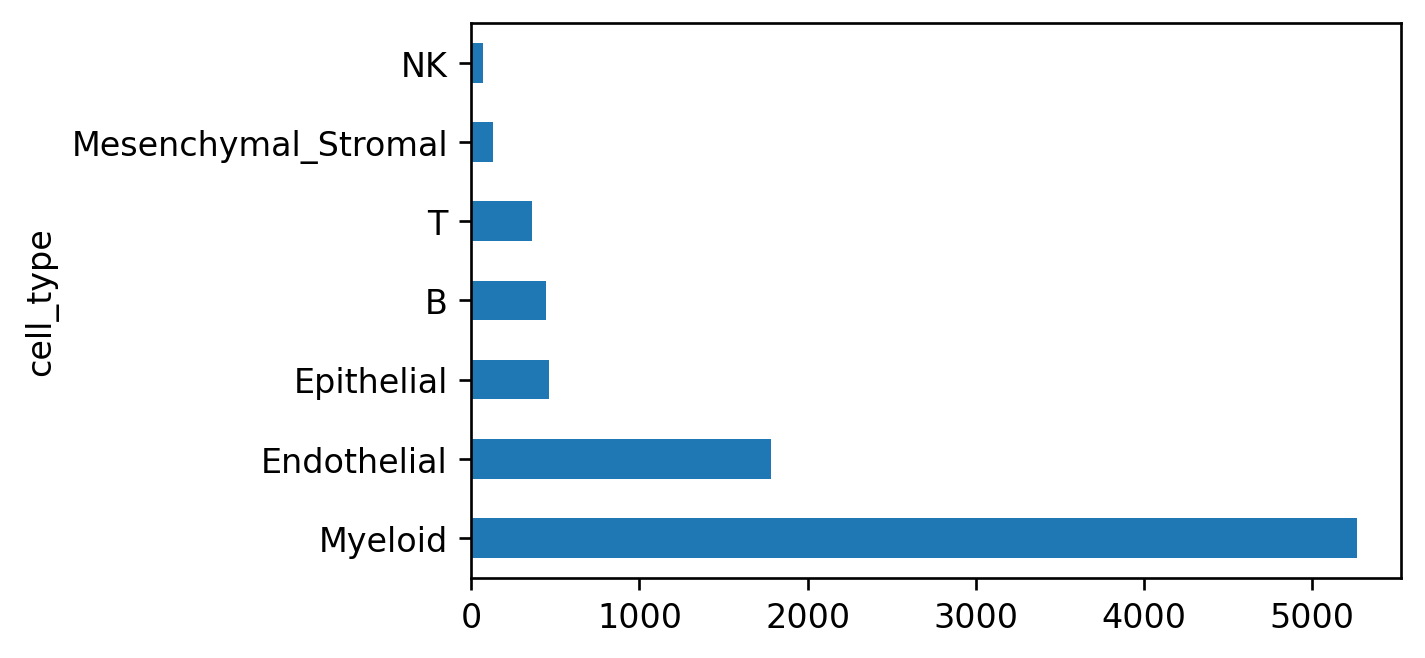

In [157]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120

adata.obs.cell_type.value_counts().plot(kind='barh')

In [158]:
osmogenes = ['Aqp2', 'Aqp4', 'Cryab', 'Elf5', 'Mal', 'Muc1',
        'Pax2', 'Sgk1', 'Slc14a2', 'Slc5a3']
hypoxia = ['Anxa2', 'Btg1', 'Cdkn1b', 'Ddit3', 'Hexa', 'Hoxb9', 'Hspa5', 'Tes']
markers = ['Wt1', 'Nphs2', 'Sord', 'Cyp2e1', 'Lrp2', 'Bst1', 'Slc4a11', 'Slc12a1', 
        'Umod', 'Slc12a3', 'Calb1', 'Aqp2', 'Aqp4']
nephron = ['Cldn1', 'Spp2', 'Lrp2', 'Aqp1', 'Sptssb', 'Slc12a1', 'Slc12a3', 'Calb1']
collecting_duct = ['Hsd11b2', 'Aqp4', 'Aqp2', 'Atp6v1g3', 'Gata3', 'Calb1']
vascular = ['Kdr', 'Cdh5', 'Vegfa', 'Emcn', 'Podxl']
hema = ['Cd52', 'Fcer1g']
immune = ['Thy1', 'Cd79a', 'Pax5']
stroma = ['Col1a1', 'Meis1', 'Postn']
podocyte = ['Pax8', 'Nphs1', 'Podxl', 'Meis1', 'Aldh1a2']

extra_genes = osmogenes + hypoxia + markers + \
    nephron + collecting_duct + vascular + hema + \
    immune + stroma + podocyte

In [159]:
adata = adata[:, ~adata.var_names.str.contains('Rik')]
adata = adata[:, ~adata.var_names.str.contains(r'^Hb\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('Hp')]
adata = adata[:, ~adata.var_names.str.startswith('Rp')]
adata = adata[:, ~adata.var_names.str.startswith('Gm')]
adata = adata[:, ~adata.var_names.str.startswith('Mir')]
adata = adata[:, ~adata.var_names.str.startswith('Ttt')]
adata = adata[:, ~adata.var_names.str.startswith('Linc')]
adata = adata[:, ~adata.var_names.str.endswith('-as1')]

In [167]:
adata.write_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')